Τίτλος: <b>ΠΟΛΥ-ΟΜΙΚΗ ΑΝΑΛΥΣΗ ΓΕΝΟΜΙΚΩΝ ΔΕΔΟΜΕΝΩΝ ΓΙΑ ΤΗΝ ΚΑΤΗΓΟΡΙΟΠΟΙΗΣΗ ΔΕΙΓΜΑΤΩΝ ΓΛΟΙΟΒΛΑΣΤΩΜΑΤΟΣ</b><br>
Ονοματεπώνυμο φοιτητή: Οικονόμου Νικόλαος<br>
Αριθμός Μητρώου: ΤΠ4845<br>
Επιβλέπων καθηγητής: Τσικνάκης Μανώλης<br>
Συν-Επιβλέπων καθηγητής: Κουμάκης Λευτέρης

Γίνεται η εισαγωγή των απαιτούμενων βιβλιοθηκών

In [1]:
# Load libraries
import numpy as np
import pandas as pd

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import tree

In [2]:
from sklearn.preprocessing import MinMaxScaler

from sklearn import svm
import matplotlib.pyplot as plt

import seaborn as sns

from imblearn.over_sampling import SMOTE
from collections import Counter

from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

Γίνεται η εισαγωγή των Datasets στην αρχική τους μορφή

In [3]:
exp = pd.read_csv("C:/Users/nikos/Desktop/exp", sep=" ") #geneExpression
methy = pd.read_csv("C:/Users/nikos/Desktop/methy", sep=" ") #DNA Methylation
mirna = pd.read_csv("C:/Users/nikos/Desktop/mirna", sep=" ") #miRNA
survival = pd.read_csv("C:/Users/nikos/Desktop/survival", sep="\t") #Survival file
clinical = pd.read_csv("C:/Users/nikos/Desktop/gbm", sep="\t") #clinical file

Στη συνέχεια για την προ-επεξεργασία των δεδομένων αλλά και την κατασκευή των μοντέλων μηχανικής μάθησης γίνεται η χρήση των παρακάτω συναρτήσεων.

Αρχικά απο το κλινικό αρχείο(clinical dataset) αφαιρούνται οι ασθενείς που έχουν NaN τιμές και "φιλτράρονται" βάση του days_to_last_followup >100  και κρατάμε σαν κλάση το CDE_vital_status, όπου έχει τιμές LIVING ή DECEASED.
Τελος, γίνονται οι απαραίτητες αλλαγές ώστε τα δεδομένα του sampleID να ειναι με τελεία(.) αντι παύλα(-) έτσι ώστε να ειναι συμβατά με τα υπόλοιπα datasets

In [4]:
def clinicalRefactor():
    #ξεχωρίζω τα columns που θέλω να κρατήσω
    df = clinical[["sampleID","CDE_vital_status", "days_to_last_followup"]]
    
    #Αφαιρώ τις NaN τιμές
    df2 = df[~df.isnull().any(axis=1)]
    
    #Βρίσκω τις days_to_last_followup >100
    df2 = df2.loc[df2.days_to_last_followup>100, ["sampleID","CDE_vital_status", "days_to_last_followup"]]
    df2=df2.reset_index(drop=True) #Κάνει το index να είναι σωστά αριθμημένο απο 0-447
    
    #Μετατρέπω τα sampleID με - σε . για να ειναι συμβατά με τα άλλα datasets
    for i in range(len(df2)):
        string = df2.loc[i,'sampleID']
        newstring = string.replace("-",".")
        df2.loc[i,'sampleID']=newstring
    
    return df2

Η παρακάτω συνάρτηση κάθε φορά που καλείται, υπολογίζει τους κοινούς ασθενείς όλων των datasets (ομικά και κλινικο σετ)

In [5]:
def findCommonPatients(genes,methylation,mirna,clinical):
    
    colNamesGenes=[]
    for i in genes.columns:
        colNamesGenes.append(i)

    colNamesMethy=[]
    for i in methylation.columns:
        colNamesMethy.append(i)

    colNamesmirna=[]
    for i in mirna.columns:
        colNamesmirna.append(i)

        
    clinicalIDs=[]
    for i in clinical['sampleID']:
        clinicalIDs.append(i)
        
    elements_in_all = list(set.intersection(*map(set, [colNamesGenes, colNamesMethy, colNamesmirna,clinicalIDs])))
    elements_in_all.sort()
    
    
    return elements_in_all

Δημιουργεί ένα νέο dataframe κάθε φορά που περιέχει τους κοινούς ασθενείς που προκύπτουν και στην κλάση στην οποια ανήκουν (DECEASED ή LIVING).

In [6]:
#βρισκει τους κοινους ασθενείς σε κάθε σετ που υπάρχουν στην λίστα commonPatients
def commonPatientsRefactor(dataframe,clinical,commonPatients):
    
    #εδώ βρίσκω τις θέσεις(indexes) που βρίσκονται τα κοινά ids στο αρχείο survival
    indexList=[]
    for i in range(len(clinical)):
        if (clinical.loc[i,'sampleID'] in commonPatients):
            indexList.append(i)

    dfT=dataframe.T #κάνω το transposed το εκάστοτε dataset

    #βρίσκω τα sampleID(index) των κοινών ασθενών στο εκάστοτε dataset - (το dataset πρέπει να είναι transposed)
    #έτσι ώστε να παραχθεί το νέο dataframe
    lista=[]
    for i in range(len(dfT)):
         if (dfT.index[i] in commonPatients):
            lista.append(i)

    #Ολοκλήρωση του νέου dataframe(προσθήκη του CDE_vital_status) 
    dataframe = dfT.iloc[lista] #ε΄δώ έχουμε το νέο dataframe χωρίς την κολώνα με το classification
    dataframe = dataframe.sort_index(ascending=True) #to sortarei
    clinincalFinal = clinical.iloc[indexList] 

    #εδώ φτιάχνω το survival dataframe να ειναι μονο με τους κοινους ασθενεις
    clinincalFinal = clinincalFinal.sort_values(by=['sampleID'])
    clinincalFinal = clinincalFinal.reset_index(drop=True)
    clinincalFinal.index = clinincalFinal['sampleID'] #ορίζω το PatientId ως index στο νέο dataframe
    clinincalFinal = clinincalFinal.drop(['sampleID'],axis=1)

    #προσθήκη της κολώνας Death στο τέλος του dataframe - εχω το τελικο dataframe
    dataframeFinalMorfi = pd.concat([dataframe,clinincalFinal['CDE_vital_status']],axis=1)

    return dataframeFinalMorfi

Η ακόλουθη συνάρτηση, normalizeData, έχει ως είσοδο κάθε dataset τη φορά και πραγματοποιεί ομαλοποίηση στα δεδομένα, μετατρέποντας τις τιμές μεταξύ 0-1. Η διαδικασία αυτή βοηθάει στη συνέχεια τους αλγορίθμους μηχανικής μάθησης Επιστρέφει το dataset σε ομαλοποιημένη μορφή.

In [7]:
def normalizeData(concatinatedDf):
    X_copy = concatinatedDf.iloc[:,:-1].copy() #Αντιγραφή του dataframe ώστε να μη "χαλάσει" το αρχικό σε περίπτωση που χρειαστεί να αναφερθούμε σε αυτο
    
    #Χρήση της συνάρτησης MinMaxScaler()
    scaler = MinMaxScaler()
    X_columns = concatinatedDf.iloc[:,:-1].columns #επλέγουμε όλες τις κολώνες πλήν της τελευταίας που ειναι οι κλάσεις μας
    X_scaled = pd.DataFrame(scaler.fit_transform(X_copy), columns=X_columns) #γίνεται ομαλοποίηση στις τιμές
    
    #Προστίθεται ξανά η κολώνα με τις κλάσεις μας και έχουμε το τελικό ομαλοποιημένο σύνολο
    last_column = concatinatedDf.iloc[: , -1]
    X_scaled.index = concatinatedDf.index
    X_scaled['CDE_vital_status'] = last_column
    
    return X_scaled

Η συνάρτηση concateDataframes, δέχεται ως είσοδο τα datasets της προηγούμενης συνάρτησης και δημιουργεί ένα νέο ενοποιημένο σύνολο δεδομένων(concatenated Dataset) το οποίο περιλαμβάνει τους κοινούς ασθενείς μεταξύ των datasets που δέχεται ως είσοδο περιλαμβάνοντας επίσης την κλάση στην οποία ανήκει ο κάθε ασθενής. Επίσης τυχόν NaN τιμές που προκύπτουν, απορρίπτει όλη τη γραμμή (row).

In [8]:
def concateDataframes(df1,df2,df3):
    newdf = pd.concat([df1,df2,df3],axis=1) #γίνεται μια "πρώτη" συνένωση των GeneExp,DNA Methylation & miRNA
    selected_rows = newdf[~newdf.isnull().any(axis=1)] #κρατάμε τις γραμμές χωρίς NaN τιμές
    
    last_column = selected_rows.iloc[: , -1]
    selected_rows.drop(selected_rows['CDE_vital_status'], axis=1, inplace=True)
    selected_rows['CDE_vital_status']=last_column
    #print(selected_rows)
    return selected_rows

Οι συναρτήσεις svmAlgorithm & treeAlgorithm εφαρμόζουν τους αλγοριθμους SVM και DecisionTree αντίστοιχα. Επιστρέφουν το y_pred και τον αντίστοιχο classifier

In [9]:
#Εφαρμογή SVM 
def svmAlgorithm(X_train, X_test, y_train, y_test):
    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) #, random_state=1

    #Δημιουργία SVM Classifier
    clf = svm.SVC(kernel='linear') # Linear Kernel

    #Εκπα΄ίδευση του μοντέλου χρησιμοποιώντας τα δεδομένα εκπαίδευσης(training sets)
    clf.fit(X_train,y_train)

    #Πρόβλεψη του μοντέλου στα δεδομένα δοκιμ΄ής(test dataset)
    y_pred = clf.predict(X_test)
    
    #print("SVM Accuracy:",metrics.accuracy_score(y_test, y_pred))
    
    return y_pred,clf
    
    #return y_test,y_pred

In [10]:
#efarmozei DecisionTree
def treeAlgorithm(X_train, X_test, y_train, y_test):
    
    #Δημιουργία DecisionTree Classifier
    clf = DecisionTreeClassifier()

    # Εκπαίδευση του  DecisionTree Classifer
    clf = clf.fit(X_train,y_train)

    #Πρόβλεψη του μοντέλου στα δεδομένα δοκιμ΄ής(test dataset)
    y_pred = clf.predict(X_test)


    #print("Decision Tree Accuracy:",metrics.accuracy_score(y_test, y_pred))
    
    return y_pred,clf
    #return y_test,y_pred
    #return clf

Η συνάρτηση confusionMatrix είναι υπεύθυνη για την δημιουργία των πινάκων σύγχυσης (confusion matrix)

In [11]:
from sklearn.metrics import ConfusionMatrixDisplay
def confusionMatrix(X_test,y_test,y_pred,clf):
    disp = plot_confusion_matrix(clf,X_test,y_test, cmap='Blues', values_format='.3g')

Η applyModels εφαρμοζει τους αλγορίθμους SVM & DecisionTree στο dataset που δέχεται ως είσοδο (normalized dataset)

In [12]:
#Εφαρμόζει SVM & DT στο κάθε dataset
#Εμφανίζει accuracies & conf matrix 
def applyModels(dfNormalize):
    data = dfNormalize.values
    X, y = data[:, :-1], data[:, -1]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) #, random_state=1

    y_pred,clf = svmAlgorithm(X_train, X_test, y_train, y_test)
    confusionMatrix(X_test,y_test,y_pred,clf)
    print("SVM Accuracy:",metrics.accuracy_score(y_test, y_pred))

    y_pred,clf = treeAlgorithm(X_train, X_test, y_train, y_test)
    print("DecisionTree Accuracy:",metrics.accuracy_score(y_test, y_pred))
    confusionMatrix(X_test,y_test,y_pred,clf)

Η applySMOTE εφαρμοζει των αλγόριθμο SMOTE και στη συνέχεια τους αλγορίθμους SVM & DecisionTree στο dataset που δέχεται ως είσοδο (normalized dataset)

In [13]:
def applySMOTE(dfNormalize):
    data = dfNormalize.values
    X, y = data[:, :-1], data[:, -1]

    #μετατροπή του dataset
    oversample = SMOTE()
    X, y = oversample.fit_resample(X, y)
    #return X,y
    
    #Μετράμε τον νέο αριθμό των κλάσεων (πόσα DECEASED και LIVING έχουμε τώρα)
    counter = Counter(y)
    print(counter)
    """
    # scatter plot of examples by class label
    for label, _ in counter.items():
        row_ix = where(y == label)[0]
        pyplot.scatter(X[row_ix, 0], X[row_ix, 1], label=str(label))
    pyplot.legend()
    pyplot.show()
    """
    #return X,y
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) #, random_state=1

    #svmAlgorithm(X_train, X_test, y_train, y_test)
    #treeAlgorithm(X_train, X_test, y_train, y_test)

    y_pred,clf = svmAlgorithm(X_train, X_test, y_train, y_test)
    confusionMatrix(X_test,y_test,y_pred,clf)
    print("SVM Accuracy:",metrics.accuracy_score(y_test, y_pred))

    y_pred,clf = treeAlgorithm(X_train, X_test, y_train, y_test)
    print("DecisionTree Accuracy:",metrics.accuracy_score(y_test, y_pred))
    confusionMatrix(X_test,y_test,y_pred,clf)
    
    return clf

### Επεξεργασία δεδομένων

Το clinical αρχείο πριν την επεξεργασία

In [43]:
clinical

,sampleID,CDE_DxAge,CDE_alk_chemoradiation_standard,CDE_chemo_adjuvant_alk,CDE_chemo_adjuvant_tmz,CDE_chemo_alk,CDE_chemo_alk_days,CDE_chemo_alk_long,CDE_chemo_tmz,CDE_chemo_tmz_days,...,_GENOMIC_ID_TCGA_GBM_exp_u133a,_GENOMIC_ID_TCGA_GBM_exp_HiSeqV2_PANCAN,_GENOMIC_ID_TCGA_GBM_RPPA_RBN,_GENOMIC_ID_TCGA_GBM_gistic2thd,_GENOMIC_ID_TCGA_GBM_PDMRNAseqCNV,_GENOMIC_ID_TCGA_GBM_mutation,_GENOMIC_ID_TCGA_GBM_exp_HiSeqV2_percentile,_GENOMIC_ID_TCGA_GBM_exp_HiSeqV2_exon,_GENOMIC_ID_TCGA_GBM_gistic2,_GENOMIC_ID_TCGA_GBM_hMethyl450
0,TCGA-02-0001-01,44.30,False,False,False,False,0.0,False,False,0.0,...,03c14838-bbab-4487-80c3-c5fdf6ec83f9,NaN,NaN,TCGA-02-0001-01C-01D-0182-01,NaN,NaN,NaN,NaN,TCGA-02-0001-01C-01D-0182-01,NaN
1,TCGA-02-0002-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,TCGA-02-0003-01,50.21,False,False,False,False,0.0,False,False,0.0,...,4298ad72-e8eb-4749-95da-cce602107724,NaN,TCGA-02-0003-01A-21-1898-20,TCGA-02-0003-01A-01D-0182-01,NaN,TCGA-02-0003-01A-01D-1490-08,NaN,NaN,TCGA-02-0003-01A-01D-0182-01,NaN
3,TCGA-02-0004-01,59.18,True,True,True,True,110.0,True,True,110.0,...,1bc1d8d2-8c34-4b03-9275-38c68323816e,NaN,TCGA-02-0004-01A-21-1898-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,TCGA-02-0006-01,56.17,False,True,True,True,61.0,True,True,61.0,...,NaN,NaN,NaN,TCGA-02-0006-01B-01D-0182-01,NaN,NaN,NaN,NaN,TCGA-02-0006-01B-01D-0182-01,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
624,TCGA-87-5896-01,50.35,False,False,False,False,0.0,False,False,0.0,...,5d4b2115-054e-4026-b2e0-9c8ec0137b57,NaN,NaN,TCGA-87-5896-01A-01D-1694-01,NaN,TCGA-87-5896-01A-01D-1696-08,NaN,NaN,TCGA-87-5896-01A-01D-1694-01,TCGA-87-5896-01A-01D-1697-05
625,TCGA-OX-A56R-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,TCGA-OX-A56R-01A-11D-A33S-01,NaN,NaN,NaN,NaN,TCGA-OX-A56R-01A-11D-A33S-01,TCGA-OX-A56R-01A-11D-A33U-05
626,TCGA-RR-A6KA-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,TCGA-RR-A6KA-01A-21D-A33S-01,NaN,NaN,NaN,NaN,TCGA-RR-A6KA-01A-21D-A33S-01,TCGA-RR-A6KA-01A-21D-A33U-05
627,TCGA-RR-A6KB-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,TCGA-RR-A6KB-01A-12D-A33S-01,NaN,NaN,NaN,NaN,TCGA-RR-A6KB-01A-12D-A33S-01,TCGA-RR-A6KB-01A-12D-A33U-05


Γίνεται το "καθάρισμα" του κλινικού αρχείο

In [14]:
clinicalFinal = clinicalRefactor()

In [15]:
clinicalFinal

,sampleID,CDE_vital_status,days_to_last_followup
0,TCGA.02.0001.01,DECEASED,279.0
1,TCGA.02.0003.01,DECEASED,144.0
2,TCGA.02.0004.01,DECEASED,345.0
3,TCGA.02.0006.01,DECEASED,558.0
4,TCGA.02.0007.01,DECEASED,705.0
...,...,...,...
442,TCGA.74.6573.01,DECEASED,105.0
443,TCGA.74.6573.11,DECEASED,105.0
444,TCGA.76.4926.01,DECEASED,138.0
445,TCGA.76.4927.01,DECEASED,535.0


In [63]:
exp

,TCGA.02.0001.01,TCGA.02.0003.01,TCGA.02.0004.01,TCGA.02.0007.01,TCGA.02.0009.01,TCGA.02.0010.01,TCGA.02.0011.01,TCGA.02.0014.01,TCGA.02.0015.01,TCGA.02.0016.01,...,TCGA.76.4932.01,TCGA.76.4934.01,TCGA.76.4935.01,TCGA.76.6191.01,TCGA.76.6192.01,TCGA.76.6193.01,TCGA.76.6282.01,TCGA.76.6285.01,TCGA.81.5910.01,TCGA.87.5896.01
AACS,6.500551,6.539245,7.377848,7.186891,7.675038,7.996010,8.355122,6.840142,6.349118,6.290033,...,5.896504,6.347784,6.192691,7.221835,7.539261,6.907754,7.007554,7.676325,7.105246,7.230189
FSTL1,8.729663,9.794400,12.059550,4.945053,10.840095,8.931571,4.240622,7.738483,10.756458,9.648899,...,8.114789,8.874452,9.920456,10.136264,9.832820,11.091805,10.789466,9.682591,9.847404,10.437573
ELMO2,5.511362,6.213981,7.051738,5.230444,6.620676,7.552416,6.707334,7.262258,7.118661,7.917984,...,7.382726,6.819251,6.675723,7.713521,7.645800,7.887724,7.569806,7.019757,7.533500,7.956918
CREB3L1,4.882953,4.836276,6.112444,5.818606,5.333213,6.087341,4.865492,4.524546,4.825061,4.831104,...,4.680993,5.636862,5.331521,5.062153,5.553267,4.687781,5.366983,4.685657,6.154893,6.813070
RPS11,10.984784,10.811245,10.436374,10.477304,10.637267,11.001533,10.685883,10.661348,10.284938,10.252175,...,10.930178,10.400120,10.351366,10.636917,10.565529,10.475093,10.572989,10.439194,10.685288,10.315563
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RPS27,12.911917,13.419446,13.229641,13.575052,13.286953,13.480339,13.474810,13.255097,12.817300,12.959185,...,13.111996,12.218949,12.564524,13.399100,13.277394,13.343416,13.178956,13.505843,13.328225,13.359426
SNRPD2,11.872288,11.109714,11.320978,11.665592,11.480397,10.951578,11.542365,11.690116,11.567203,10.862274,...,11.599531,10.725661,10.909147,11.381900,10.622078,10.161330,10.877981,10.572219,11.180936,10.224787
SLC39A6,6.867686,8.147826,8.519248,9.189867,8.556436,9.209863,8.437613,10.204783,9.501426,9.258881,...,8.524940,9.047400,8.841615,10.154077,9.378793,9.264921,8.839641,8.887161,9.816206,9.860658
CTSC,10.354085,11.367438,10.379502,11.478158,10.404706,8.417933,10.242709,9.188361,10.596505,7.505618,...,9.562364,9.154262,8.866970,9.323397,9.367210,10.778728,9.977945,9.466206,8.005893,8.068711


In [64]:
methy

,TCGA.02.0001.01,TCGA.02.0003.01,TCGA.02.0006.01,TCGA.02.0007.01,TCGA.02.0009.01,TCGA.02.0010.01,TCGA.02.0011.01,TCGA.02.0014.01,TCGA.02.0021.01,TCGA.02.0024.01,...,TCGA.32.4213.01,TCGA.32.4719.01,TCGA.41.2571.01,TCGA.41.2572.01,TCGA.41.2573.01,TCGA.41.2575.01,TCGA.41.3392.01,TCGA.41.3393.01,TCGA.41.3915.01,TCGA.41.4097.01
cg00000292,0.826063,0.696610,0.636458,0.826712,0.836044,0.687137,0.054562,0.663312,0.733456,0.157862,...,0.567572,0.628800,0.612897,0.597697,0.400045,0.064723,0.315678,0.704422,0.475091,0.800415
cg00002426,0.178659,0.555948,0.296783,0.088165,0.194659,0.912093,0.067209,0.062254,0.134492,0.175281,...,0.268619,0.209767,0.093338,0.131811,0.100287,0.068986,0.054030,0.286588,0.192033,0.313302
cg00005847,0.381919,0.851630,0.509650,0.404206,0.635270,0.876321,0.054024,0.871905,0.108630,0.864615,...,0.545096,0.862530,0.685521,0.577767,0.470516,0.614811,0.165496,0.615784,0.531287,0.434784
cg00015770,0.045782,0.035110,0.060242,0.218564,0.367296,0.114126,0.059143,0.113228,0.062716,0.033215,...,0.065244,0.125382,0.423369,0.722128,0.475888,0.391715,0.412727,0.112660,0.117995,0.278564
cg00027083,0.025546,0.879701,0.167647,0.019343,0.882392,0.019867,0.041625,0.019458,0.846316,0.108331,...,0.206994,0.792925,0.349835,0.786483,0.623773,0.152668,0.547546,0.486311,0.140576,0.324858
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cg27631817,0.554642,0.565593,0.586694,0.540277,0.267711,0.690687,0.285369,0.306126,0.084542,0.547602,...,0.339596,0.464966,0.319852,0.575210,0.723555,0.149494,0.321311,0.176945,0.576530,0.610846
cg27634151,0.397459,0.796378,0.412954,0.336352,0.167398,0.020685,0.024314,0.034892,0.488109,0.015764,...,0.027021,0.561223,0.289071,0.195711,0.038473,0.440628,0.569706,0.141038,0.411164,0.361882
cg27637521,0.187017,0.154289,0.560711,0.018567,0.732823,0.909901,0.866263,0.964462,0.235631,0.065486,...,0.105982,0.846025,0.618061,0.801446,0.124373,0.441923,0.739629,0.293696,0.608434,0.555208
cg27644292,0.497505,0.487170,0.517018,0.539949,0.267666,0.497682,0.209014,0.276316,0.706698,0.713053,...,0.398366,0.389248,0.215415,0.453333,0.255165,0.545321,0.196059,0.480987,0.130900,0.460593


In [65]:
mirna

,TCGA.02.0001.01,TCGA.02.0003.01,TCGA.02.0004.01,TCGA.02.0006.01,TCGA.02.0007.01,TCGA.02.0009.01,TCGA.02.0010.01,TCGA.02.0011.01,TCGA.02.0014.01,TCGA.02.0015.01,...,TCGA.76.6656.01,TCGA.76.6657.01,TCGA.76.6660.01,TCGA.76.6661.01,TCGA.76.6662.01,TCGA.76.6663.01,TCGA.76.6664.01,TCGA.81.5910.01,TCGA.81.5911.01,TCGA.87.5896.01
ebv-miR-BART1-3p,5.855126,5.801614,5.771332,5.763649,5.818828,5.766792,5.830012,5.694577,5.759589,5.721678,...,5.712632,5.694990,5.698417,5.719659,5.668525,5.684801,5.734061,5.720782,5.719152,5.794120
ebv-miR-BART1-5p,5.799428,5.790478,5.758764,5.800184,5.800582,5.812545,5.762413,5.781372,5.753567,5.784598,...,5.727255,5.722858,5.708546,5.697037,5.705371,5.681921,5.674293,5.708005,5.680210,5.762432
ebv-miR-BART10,5.862059,5.818763,5.825401,5.831836,5.818181,5.888331,5.805194,5.826315,5.824671,5.822451,...,5.803882,5.801242,5.792297,5.736406,5.768526,5.716620,5.711762,5.935674,5.728364,5.727276
ebv-miR-BART11-3p,5.608860,5.613089,6.093861,5.670716,5.585730,5.948601,5.976939,5.852204,5.851923,5.810710,...,5.934556,5.920896,5.940554,5.898606,5.937124,5.960253,5.954465,5.960937,5.857153,6.050409
ebv-miR-BART11-5p,5.812956,5.768700,5.735270,5.744179,5.785541,5.803021,5.766500,5.706884,5.703376,5.739655,...,5.678864,5.676394,5.661590,5.715214,5.682542,5.669467,5.667814,5.680227,5.730056,5.782263
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
kshv-miR-K12-6-5p,5.770694,6.111412,5.765020,5.705503,5.717107,5.755163,5.779894,5.714455,5.714449,5.712110,...,5.633753,5.693844,5.674858,5.655175,5.665539,5.651218,5.698251,5.707501,5.670749,5.749869
kshv-miR-K12-7,5.954499,5.913446,5.865792,6.237077,5.935077,5.914048,5.930807,6.101921,5.984673,5.853593,...,5.812078,5.923279,5.902711,5.967153,6.070630,6.235935,6.371940,6.014055,5.689360,5.921934
kshv-miR-K12-8,5.892369,5.956731,5.969540,5.984284,6.060616,6.048225,6.039319,6.068896,6.124705,6.077319,...,6.017790,6.089508,6.031124,6.179824,6.052631,6.112435,6.069233,6.097343,5.888891,5.899600
kshv-miR-K12-9,5.740376,5.678515,5.707225,5.685517,5.669469,5.699241,5.670584,5.681757,5.645373,5.669122,...,5.578846,5.621052,5.619350,5.679258,5.631265,5.587535,5.616982,5.639963,5.617586,5.687209


Βρισκω τους κοινους ασθενεις ολων των αρχειων (genes,methylation,miRNA,survival)

In [16]:
commonPatients = findCommonPatients(exp,methy,mirna,clinicalFinal)
commonPatients

['TCGA.02.0001.01',
 'TCGA.02.0003.01',
 'TCGA.02.0007.01',
 'TCGA.02.0009.01',
 'TCGA.02.0010.01',
 'TCGA.02.0011.01',
 'TCGA.02.0014.01',
 'TCGA.02.0021.01',
 'TCGA.02.0024.01',
 'TCGA.02.0027.01',
 'TCGA.02.0028.01',
 'TCGA.02.0034.01',
 'TCGA.02.0038.01',
 'TCGA.02.0043.01',
 'TCGA.02.0047.01',
 'TCGA.02.0052.01',
 'TCGA.02.0054.01',
 'TCGA.02.0057.01',
 'TCGA.02.0058.01',
 'TCGA.02.0060.01',
 'TCGA.02.0064.01',
 'TCGA.02.0069.01',
 'TCGA.02.0071.01',
 'TCGA.02.0074.01',
 'TCGA.02.0075.01',
 'TCGA.02.0080.01',
 'TCGA.02.0083.01',
 'TCGA.02.0085.01',
 'TCGA.02.0086.01',
 'TCGA.02.0089.01',
 'TCGA.02.0099.01',
 'TCGA.02.0102.01',
 'TCGA.02.0107.01',
 'TCGA.02.0113.01',
 'TCGA.02.0114.01',
 'TCGA.02.0115.01',
 'TCGA.02.0116.01',
 'TCGA.02.2466.01',
 'TCGA.02.2470.01',
 'TCGA.02.2483.01',
 'TCGA.02.2485.01',
 'TCGA.02.2486.01',
 'TCGA.06.0124.01',
 'TCGA.06.0125.01',
 'TCGA.06.0128.01',
 'TCGA.06.0129.01',
 'TCGA.06.0130.01',
 'TCGA.06.0133.01',
 'TCGA.06.0137.01',
 'TCGA.06.0139.01',


In [17]:
len(commonPatients)

230

In [18]:
test1Genes = commonPatientsRefactor(exp,clinicalFinal,commonPatients)
test2Methylation = commonPatientsRefactor(methy,clinicalFinal,commonPatients)
test3mirna = commonPatientsRefactor(mirna,clinicalFinal,commonPatients)

In [37]:
test1Genes

,AACS,FSTL1,ELMO2,CREB3L1,RPS11,PNMA1,MMP2,SAMD4A,SMARCD3,A4GNT,...,DHRS2,RAB8A,SGEF,PIK3IP1,RPS27,SNRPD2,SLC39A6,CTSC,AQP7,CDE_vital_status
sampleID,,,,,,,,,,,,,,,,,,,,,
TCGA.02.0001.01,6.500551,8.729663,5.511362,4.882953,10.984784,7.535193,8.674010,5.032552,4.710970,5.108478,...,7.153611,9.048851,4.366050,6.054001,12.911917,11.872288,6.867686,10.354085,4.709882,DECEASED
TCGA.02.0003.01,6.539245,9.794400,6.213981,4.836276,10.811245,6.997933,9.348590,5.026961,5.327734,4.348606,...,4.006913,8.864498,4.385314,6.674161,13.419446,11.109714,8.147826,11.367438,4.196368,DECEASED
TCGA.02.0007.01,7.186891,4.945053,5.230444,5.818606,10.477304,8.356117,4.429521,5.175938,4.440470,4.824183,...,4.290511,8.483590,4.798488,5.060176,13.575052,11.665592,9.189867,11.478158,4.323108,DECEASED
TCGA.02.0009.01,7.675038,10.840095,6.620676,5.333213,10.637267,6.942901,9.452231,5.164914,4.952207,4.204604,...,5.410476,9.239238,4.343192,6.478035,13.286953,11.480397,8.556436,10.404706,4.639090,DECEASED
TCGA.02.0010.01,7.996010,8.931571,7.552416,6.087341,11.001533,8.044375,4.501725,4.970135,8.638965,4.729682,...,4.388377,9.367783,4.219649,5.704774,13.480339,10.951578,9.209863,8.417933,4.167286,DECEASED
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA.41.2572.01,7.564477,10.626080,7.830206,4.874744,10.974133,9.512059,8.568646,5.998493,8.806333,4.407308,...,4.085567,8.949573,6.621713,5.666419,13.044853,11.532611,9.143708,8.646577,3.935895,DECEASED
TCGA.41.2573.01,8.352362,9.278117,8.222441,4.438118,10.934162,10.417580,7.775023,5.161021,9.229107,4.230057,...,4.084781,8.700344,5.308027,7.295997,13.176338,11.169791,10.107092,9.284950,3.660217,LIVING
TCGA.41.2575.01,7.470726,9.022293,7.268008,4.886906,11.152242,9.087012,8.191436,5.380936,9.408020,4.376040,...,4.132281,8.511591,5.876536,6.033707,13.487420,11.493752,9.942114,8.535658,3.852216,DECEASED


In [38]:
test2Methylation

,cg00000292,cg00002426,cg00005847,cg00015770,cg00027083,cg00029931,cg00030047,cg00041575,cg00043004,cg00056767,...,cg27622610,cg27626299,cg27626424,cg27631256,cg27631817,cg27634151,cg27637521,cg27644292,cg27652350,CDE_vital_status
sampleID,,,,,,,,,,,,,,,,,,,,,
TCGA.02.0001.01,0.826063,0.178659,0.381919,0.045782,0.025546,0.073651,0.326046,0.640585,0.637638,0.030499,...,0.615740,0.057134,0.959526,0.684796,0.554642,0.397459,0.187017,0.497505,0.394196,DECEASED
TCGA.02.0003.01,0.696610,0.555948,0.851630,0.035110,0.879701,0.063262,0.819071,0.549288,0.840612,0.082296,...,0.559221,0.213944,0.324858,0.822721,0.565593,0.796378,0.154289,0.487170,0.708835,DECEASED
TCGA.02.0007.01,0.826712,0.088165,0.404206,0.218564,0.019343,0.393609,0.923292,0.770041,0.888077,0.173058,...,0.608953,0.564084,0.927312,0.846220,0.540277,0.336352,0.018567,0.539949,0.286335,DECEASED
TCGA.02.0009.01,0.836044,0.194659,0.635270,0.367296,0.882392,0.541412,0.849001,0.709482,0.407752,0.078154,...,0.398277,0.454173,0.750603,0.785953,0.267711,0.167398,0.732823,0.267666,0.118891,DECEASED
TCGA.02.0010.01,0.687137,0.912093,0.876321,0.114126,0.019867,0.025253,0.495842,0.696550,0.868179,0.932783,...,0.023956,0.040229,0.942546,0.871800,0.690687,0.020685,0.909901,0.497682,0.975305,DECEASED
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA.41.2572.01,0.597697,0.131811,0.577767,0.722128,0.786483,0.020554,0.824263,0.734042,0.389067,0.101514,...,0.378802,0.536203,0.884746,0.801957,0.575210,0.195711,0.801446,0.453333,0.840355,DECEASED
TCGA.41.2573.01,0.400045,0.100287,0.470516,0.475888,0.623773,0.019328,0.392965,0.329292,0.255324,0.028058,...,0.185722,0.198935,0.636345,0.718664,0.723555,0.038473,0.124373,0.255165,0.091791,LIVING
TCGA.41.2575.01,0.064723,0.068986,0.614811,0.391715,0.152668,0.026295,0.826769,0.606009,0.291700,0.027509,...,0.093729,0.162311,0.701911,0.751347,0.149494,0.440628,0.441923,0.545321,0.504936,DECEASED


In [39]:
test3mirna

,ebv-miR-BART1-3p,ebv-miR-BART1-5p,ebv-miR-BART10,ebv-miR-BART11-3p,ebv-miR-BART11-5p,ebv-miR-BART12,ebv-miR-BART13,ebv-miR-BART14-3p,ebv-miR-BART14-5p,ebv-miR-BART15,...,kshv-miR-K12-4-3p,kshv-miR-K12-4-5p,kshv-miR-K12-5,kshv-miR-K12-6-3p,kshv-miR-K12-6-5p,kshv-miR-K12-7,kshv-miR-K12-8,kshv-miR-K12-9,kshv-miR-K12-9*,CDE_vital_status
sampleID,,,,,,,,,,,,,,,,,,,,,
TCGA.02.0001.01,5.855126,5.799428,5.862059,5.608860,5.812956,5.932238,7.417908,5.769454,5.789184,5.946758,...,5.745194,5.811312,5.736368,5.728056,5.770694,5.954499,5.892369,5.740376,5.537198,DECEASED
TCGA.02.0003.01,5.801614,5.790478,5.818763,5.613089,5.768700,5.870240,7.314205,5.747051,5.795356,5.853679,...,5.765822,5.800511,5.721188,6.379601,6.111412,5.913446,5.956731,5.678515,5.419889,DECEASED
TCGA.02.0007.01,5.818828,5.800582,5.818181,5.585730,5.785541,5.897554,7.347849,5.804559,5.803284,5.802757,...,5.723913,5.850117,5.724573,5.763876,5.717107,5.935077,6.060616,5.669469,5.549034,DECEASED
TCGA.02.0009.01,5.766792,5.812545,5.888331,5.948601,5.803021,5.935245,7.933744,5.756250,5.754840,5.839917,...,5.775323,5.835817,5.725099,5.759675,5.755163,5.914048,6.048225,5.699241,6.090615,DECEASED
TCGA.02.0010.01,5.830012,5.762413,5.805194,5.976939,5.766500,5.866709,7.811017,5.791926,5.744780,5.791533,...,5.775821,5.780900,5.744699,5.749399,5.779894,5.930807,6.039319,5.670584,6.109396,DECEASED
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA.41.2572.01,5.876953,5.856112,5.905694,6.153589,5.866547,5.869405,10.290012,5.807951,5.995493,5.832601,...,5.875839,5.853907,5.827569,5.833643,5.865865,7.427244,6.623049,5.729454,6.028290,DECEASED
TCGA.41.2573.01,5.768540,5.782876,5.821910,5.952710,5.750902,5.845650,7.598841,5.780203,5.776816,5.821024,...,5.776287,5.832648,5.734893,5.741830,5.717042,5.913589,6.025606,5.694794,5.761544,LIVING
TCGA.41.2575.01,5.760604,5.740049,5.809435,6.067070,5.732453,5.799317,7.897456,5.773762,5.781377,5.723617,...,5.775477,5.826861,5.734939,5.761533,5.704507,5.856054,6.205086,5.697359,5.818565,DECEASED


Γινεται ομαλοποίηση (0-1) σε ολα τα datasets

In [19]:
genesN = normalizeData(test1Genes)
methyN = normalizeData(test2Methylation)
mirnaN = normalizeData(test3mirna)

In [40]:
genesN

,AACS,FSTL1,ELMO2,CREB3L1,RPS11,PNMA1,MMP2,SAMD4A,SMARCD3,A4GNT,...,DHRS2,RAB8A,SGEF,PIK3IP1,RPS27,SNRPD2,SLC39A6,CTSC,AQP7,CDE_vital_status
sampleID,,,,,,,,,,,,,,,,,,,,,
TCGA.02.0001.01,0.249831,0.614165,0.149741,0.227189,0.451030,0.292097,0.718822,0.092452,0.160680,1.000000,...,0.474529,0.631204,0.075802,0.444703,0.457372,0.795956,0.204717,0.737955,0.743869,DECEASED
TCGA.02.0003.01,0.259859,0.743213,0.370099,0.216045,0.368801,0.182436,0.818184,0.089434,0.256339,0.315462,...,0.037679,0.565080,0.080365,0.654378,0.766348,0.594585,0.424126,0.926536,0.460936,DECEASED
TCGA.02.0007.01,0.427716,0.155465,0.061639,0.450566,0.210567,0.459657,0.093631,0.169854,0.118726,0.743891,...,0.077051,0.428455,0.178246,0.108692,0.861078,0.741374,0.602727,0.947140,0.530766,DECEASED
TCGA.02.0009.01,0.554233,0.869953,0.497648,0.334683,0.286364,0.171204,0.833450,0.163903,0.198096,0.185737,...,0.232533,0.699492,0.070387,0.588068,0.685688,0.692470,0.494160,0.747375,0.704864,DECEASED
TCGA.02.0010.01,0.637423,0.638637,0.789864,0.514724,0.458967,0.396027,0.104266,0.058759,0.769906,0.658758,...,0.090637,0.745599,0.041119,0.326629,0.803418,0.552826,0.606154,0.377644,0.444912,DECEASED
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA.41.2572.01,0.525578,0.844014,0.876986,0.225229,0.445983,0.695598,0.703303,0.613876,0.795864,0.368345,...,0.048599,0.595595,0.610166,0.313662,0.538301,0.706258,0.594815,0.420194,0.317421,DECEASED
TCGA.41.2573.01,0.729782,0.680639,1.000000,0.120989,0.427044,0.880425,0.586406,0.161801,0.861436,0.208667,...,0.048489,0.506201,0.298955,0.864619,0.618347,0.610449,0.759934,0.538993,0.165530,LIVING
TCGA.41.2575.01,0.501280,0.649632,0.700667,0.228132,0.530378,0.608841,0.647741,0.280514,0.889185,0.340176,...,0.055084,0.438498,0.433634,0.437841,0.807729,0.695997,0.731658,0.399552,0.271316,DECEASED


In [41]:
methyN

,cg00000292,cg00002426,cg00005847,cg00015770,cg00027083,cg00029931,cg00030047,cg00041575,cg00043004,cg00056767,...,cg27622610,cg27626299,cg27626424,cg27631256,cg27631817,cg27634151,cg27637521,cg27644292,cg27652350,CDE_vital_status
sampleID,,,,,,,,,,,,,,,,,,,,,
TCGA.02.0001.01,0.880237,0.177072,0.372185,0.028212,0.022866,0.112598,0.335274,0.673516,0.671107,0.021348,...,0.634403,0.061604,0.973947,0.720294,0.579511,0.493379,0.189524,0.481324,0.394326,DECEASED
TCGA.02.0003.01,0.736205,0.594270,0.887544,0.014792,0.964493,0.095092,0.872397,0.569080,0.887950,0.075775,...,0.574758,0.262108,0.192561,0.883529,0.591528,1.000000,0.155406,0.468568,0.719856,DECEASED
TCGA.02.0007.01,0.880959,0.077005,0.396638,0.245459,0.016028,0.651733,0.985940,0.821604,0.938658,0.171146,...,0.627240,0.709814,0.934286,0.911339,0.563747,0.415773,0.013917,0.533711,0.282732,DECEASED
TCGA.02.0009.01,0.891341,0.194765,0.650157,0.432468,0.967459,0.900783,0.905004,0.752329,0.425515,0.071423,...,0.404914,0.569276,0.716727,0.840013,0.264641,0.201205,0.758520,0.197643,0.109492,DECEASED
TCGA.02.0010.01,0.725664,0.988089,0.914634,0.114143,0.016605,0.031047,0.520257,0.737536,0.917401,0.969452,...,0.009895,0.039988,0.953042,0.941613,0.728803,0.014881,0.943121,0.481543,0.995550,DECEASED
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA.41.2572.01,0.626151,0.125268,0.587066,0.878618,0.861729,0.023128,0.878054,0.780423,0.405553,0.095970,...,0.384363,0.674163,0.881880,0.858954,0.602081,0.237162,0.830059,0.426804,0.855928,DECEASED
TCGA.41.2573.01,0.406240,0.090410,0.469392,0.569006,0.682356,0.021063,0.408179,0.317422,0.262671,0.018783,...,0.180606,0.242916,0.576055,0.760377,0.764871,0.037472,0.124218,0.182213,0.081453,LIVING
TCGA.41.2575.01,0.033154,0.055797,0.627711,0.463171,0.163006,0.032803,0.880784,0.633964,0.301533,0.018206,...,0.083526,0.196087,0.656779,0.799057,0.134913,0.548202,0.455260,0.540342,0.508899,DECEASED


In [42]:
mirnaN

,ebv-miR-BART1-3p,ebv-miR-BART1-5p,ebv-miR-BART10,ebv-miR-BART11-3p,ebv-miR-BART11-5p,ebv-miR-BART12,ebv-miR-BART13,ebv-miR-BART14-3p,ebv-miR-BART14-5p,ebv-miR-BART15,...,kshv-miR-K12-4-3p,kshv-miR-K12-4-5p,kshv-miR-K12-5,kshv-miR-K12-6-3p,kshv-miR-K12-6-5p,kshv-miR-K12-7,kshv-miR-K12-8,kshv-miR-K12-9,kshv-miR-K12-9*,CDE_vital_status
sampleID,,,,,,,,,,,,,,,,,,,,,
TCGA.02.0001.01,0.184576,0.264263,0.313195,0.015189,0.301606,0.328438,0.229045,0.295857,0.190180,0.530660,...,0.086404,0.136568,0.166382,0.082767,0.158880,0.160249,0.110777,0.377625,0.141433,DECEASED
TCGA.02.0003.01,0.134229,0.243247,0.205467,0.017966,0.205903,0.255939,0.201208,0.234734,0.201509,0.349151,...,0.119229,0.120196,0.133401,1.000000,0.698447,0.141205,0.170575,0.220051,0.042647,DECEASED
TCGA.02.0007.01,0.150425,0.266971,0.204021,0.000000,0.242322,0.287878,0.210239,0.391633,0.216061,0.249850,...,0.052540,0.195386,0.140754,0.133194,0.074018,0.151239,0.267093,0.197010,0.151400,DECEASED
TCGA.02.0009.01,0.101466,0.295061,0.378564,0.238297,0.280121,0.331953,0.367510,0.259832,0.127139,0.322314,...,0.134347,0.173711,0.141897,0.127280,0.134284,0.141484,0.255580,0.272845,0.607467,DECEASED
TCGA.02.0010.01,0.160948,0.177352,0.171705,0.256907,0.201144,0.251810,0.334567,0.357167,0.108673,0.227962,...,0.135140,0.090472,0.184482,0.112813,0.173449,0.149259,0.247306,0.199850,0.623282,DECEASED
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA.41.2572.01,0.205112,0.397355,0.421767,0.372912,0.417499,0.254962,1.000000,0.400887,0.568876,0.308047,...,0.294295,0.201132,0.364532,0.231411,0.309594,0.843427,0.789637,0.349805,0.554982,DECEASED
TCGA.41.2573.01,0.103111,0.225398,0.213298,0.240995,0.167413,0.227184,0.277613,0.325183,0.167478,0.285473,...,0.135882,0.168908,0.163176,0.102158,0.073916,0.141272,0.234565,0.261517,0.330355,LIVING
TCGA.41.2575.01,0.095644,0.124840,0.182257,0.316095,0.127517,0.173003,0.357770,0.307611,0.175850,0.095522,...,0.134593,0.160137,0.163276,0.129895,0.054064,0.114582,0.401317,0.268053,0.378372,DECEASED


Κανει συνένωση των ομαλοποιημένων σετς

In [20]:
concDf = concateDataframes(genesN,methyN,mirnaN)

In [21]:
concDf

,AACS,FSTL1,ELMO2,CREB3L1,RPS11,PNMA1,MMP2,SAMD4A,SMARCD3,A4GNT,...,kshv-miR-K12-4-3p,kshv-miR-K12-4-5p,kshv-miR-K12-5,kshv-miR-K12-6-3p,kshv-miR-K12-6-5p,kshv-miR-K12-7,kshv-miR-K12-8,kshv-miR-K12-9,kshv-miR-K12-9*,CDE_vital_status
sampleID,,,,,,,,,,,,,,,,,,,,,
TCGA.02.0001.01,0.249831,0.614165,0.149741,0.227189,0.451030,0.292097,0.718822,0.092452,0.160680,1.000000,...,0.086404,0.136568,0.166382,0.082767,0.158880,0.160249,0.110777,0.377625,0.141433,DECEASED
TCGA.02.0003.01,0.259859,0.743213,0.370099,0.216045,0.368801,0.182436,0.818184,0.089434,0.256339,0.315462,...,0.119229,0.120196,0.133401,1.000000,0.698447,0.141205,0.170575,0.220051,0.042647,DECEASED
TCGA.02.0007.01,0.427716,0.155465,0.061639,0.450566,0.210567,0.459657,0.093631,0.169854,0.118726,0.743891,...,0.052540,0.195386,0.140754,0.133194,0.074018,0.151239,0.267093,0.197010,0.151400,DECEASED
TCGA.02.0009.01,0.554233,0.869953,0.497648,0.334683,0.286364,0.171204,0.833450,0.163903,0.198096,0.185737,...,0.134347,0.173711,0.141897,0.127280,0.134284,0.141484,0.255580,0.272845,0.607467,DECEASED
TCGA.02.0010.01,0.637423,0.638637,0.789864,0.514724,0.458967,0.396027,0.104266,0.058759,0.769906,0.658758,...,0.135140,0.090472,0.184482,0.112813,0.173449,0.149259,0.247306,0.199850,0.623282,DECEASED
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA.41.2572.01,0.525578,0.844014,0.876986,0.225229,0.445983,0.695598,0.703303,0.613876,0.795864,0.368345,...,0.294295,0.201132,0.364532,0.231411,0.309594,0.843427,0.789637,0.349805,0.554982,DECEASED
TCGA.41.2573.01,0.729782,0.680639,1.000000,0.120989,0.427044,0.880425,0.586406,0.161801,0.861436,0.208667,...,0.135882,0.168908,0.163176,0.102158,0.073916,0.141272,0.234565,0.261517,0.330355,LIVING
TCGA.41.2575.01,0.501280,0.649632,0.700667,0.228132,0.530378,0.608841,0.647741,0.280514,0.889185,0.340176,...,0.134593,0.160137,0.163276,0.129895,0.054064,0.114582,0.401317,0.268053,0.378372,DECEASED


In [22]:
concDf['CDE_vital_status'].value_counts()['DECEASED']

169

In [23]:
concDf['CDE_vital_status'].value_counts()['LIVING']

61

Εδω φαίνεται ο αριθμός των δειγμάτων σε κάθε κλάση

Παρατηρούμε οτι το σύνολο ειναι ανισόρροπο (imbalanced)

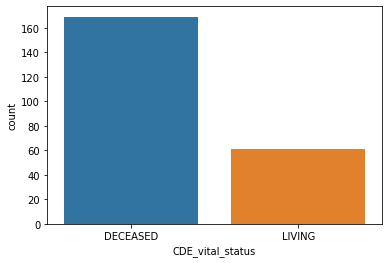

In [24]:
g = sns.countplot(concDf['CDE_vital_status'])
g.set_xticklabels(['DECEASED','LIVING'])
plt.show()

##### Στο στάδιο αυτό έχει ολοκληρωθεί η προ-επεξεργασία των δεδομένων μας και τώρα θα εφαρμόσουμε τα δεδομένα στους αλγορίθμους SVM και DecisionTree

Χρήση των προαναφερθέντων αλγορίθμων σε κάθε dataset μεμονωμένα και στο ενοποιημένο σύνολο δεδομένων χωρίς την χρήση του αλγορίθμου SMOTE. Επίσης, εκτυπώνεται το ποσοστό ακρίβειας του κάθε μοντέλου αλλά και ο πίνακας σύγχυσής του.

Για το dataset GeneExpression έχουμε:

SVM Accuracy: 0.7101449275362319
DecisionTree Accuracy: 0.6231884057971014


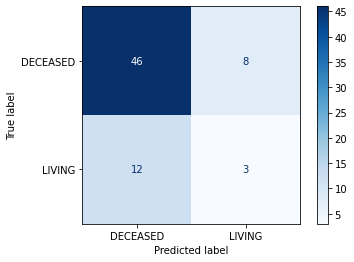

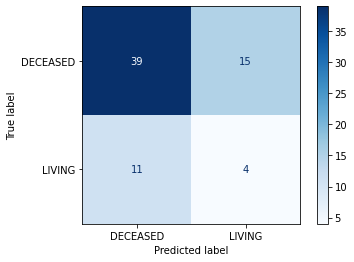

In [25]:
applyModels(genesN)

Για το dataset DNA Methylation έχουμε:

SVM Accuracy: 0.782608695652174
DecisionTree Accuracy: 0.6086956521739131


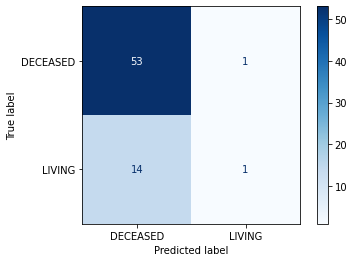

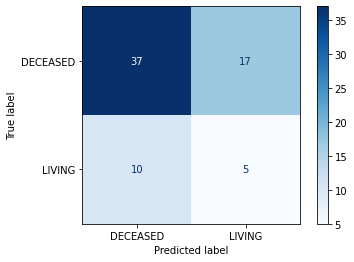

In [26]:
applyModels(methyN)

Για το dataset miRNA έχουμε:

SVM Accuracy: 0.5652173913043478
DecisionTree Accuracy: 0.5362318840579711


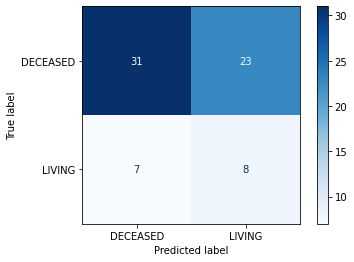

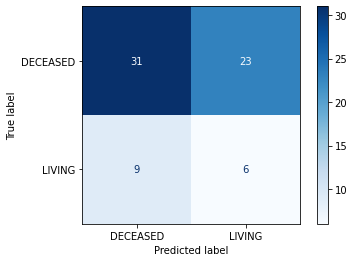

In [27]:
applyModels(mirnaN)

Για το ενοποιημένο σύνολο έχουμε:

SVM Accuracy: 0.6956521739130435
DecisionTree Accuracy: 0.6086956521739131


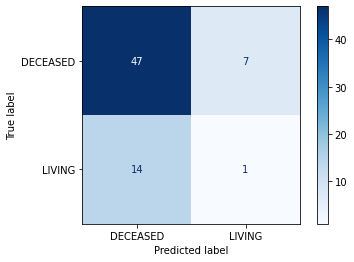

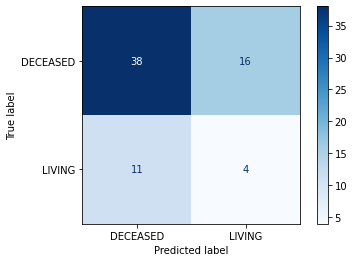

In [28]:
applyModels(concDf)

### Εφαρμογή του SMOTE

Για το genes Expression έχουμε:

Counter({'DECEASED': 169, 'LIVING': 169})
SVM Accuracy: 0.9019607843137255
DecisionTree Accuracy: 0.7156862745098039


DecisionTreeClassifier()

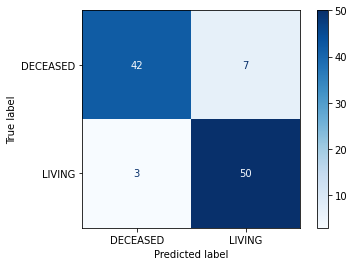

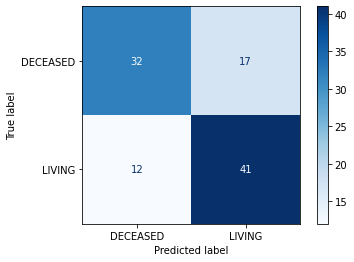

In [29]:
applySMOTE(genesN)

Για το DNA Methylation έχουμε

Counter({'DECEASED': 169, 'LIVING': 169})
SVM Accuracy: 0.8823529411764706
DecisionTree Accuracy: 0.6862745098039216


DecisionTreeClassifier()

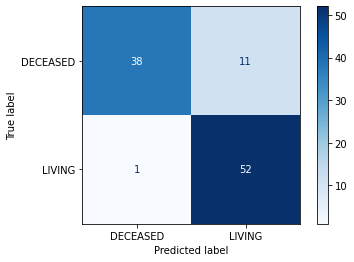

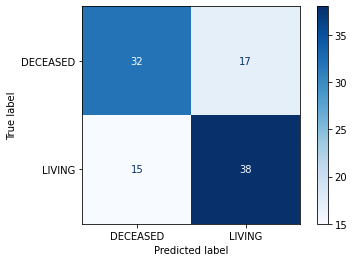

In [30]:
applySMOTE(methyN)

Για το miRNA έχουμε:

Counter({'DECEASED': 169, 'LIVING': 169})
SVM Accuracy: 0.7352941176470589
DecisionTree Accuracy: 0.7352941176470589


DecisionTreeClassifier()

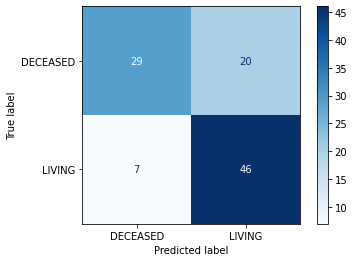

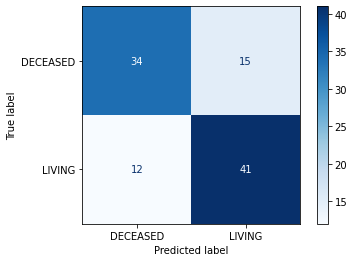

In [31]:
applySMOTE(mirnaN)

Για το ενοποιημένο σύνολο έχουμε:

Counter({'DECEASED': 169, 'LIVING': 169})
SVM Accuracy: 0.8823529411764706
DecisionTree Accuracy: 0.7254901960784313


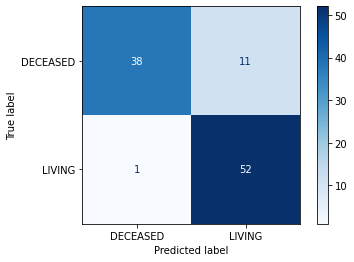

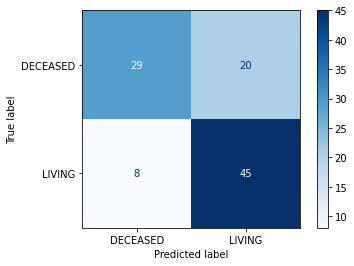

In [32]:
clf = applySMOTE(concDf)

EXPORT DECISION TREE

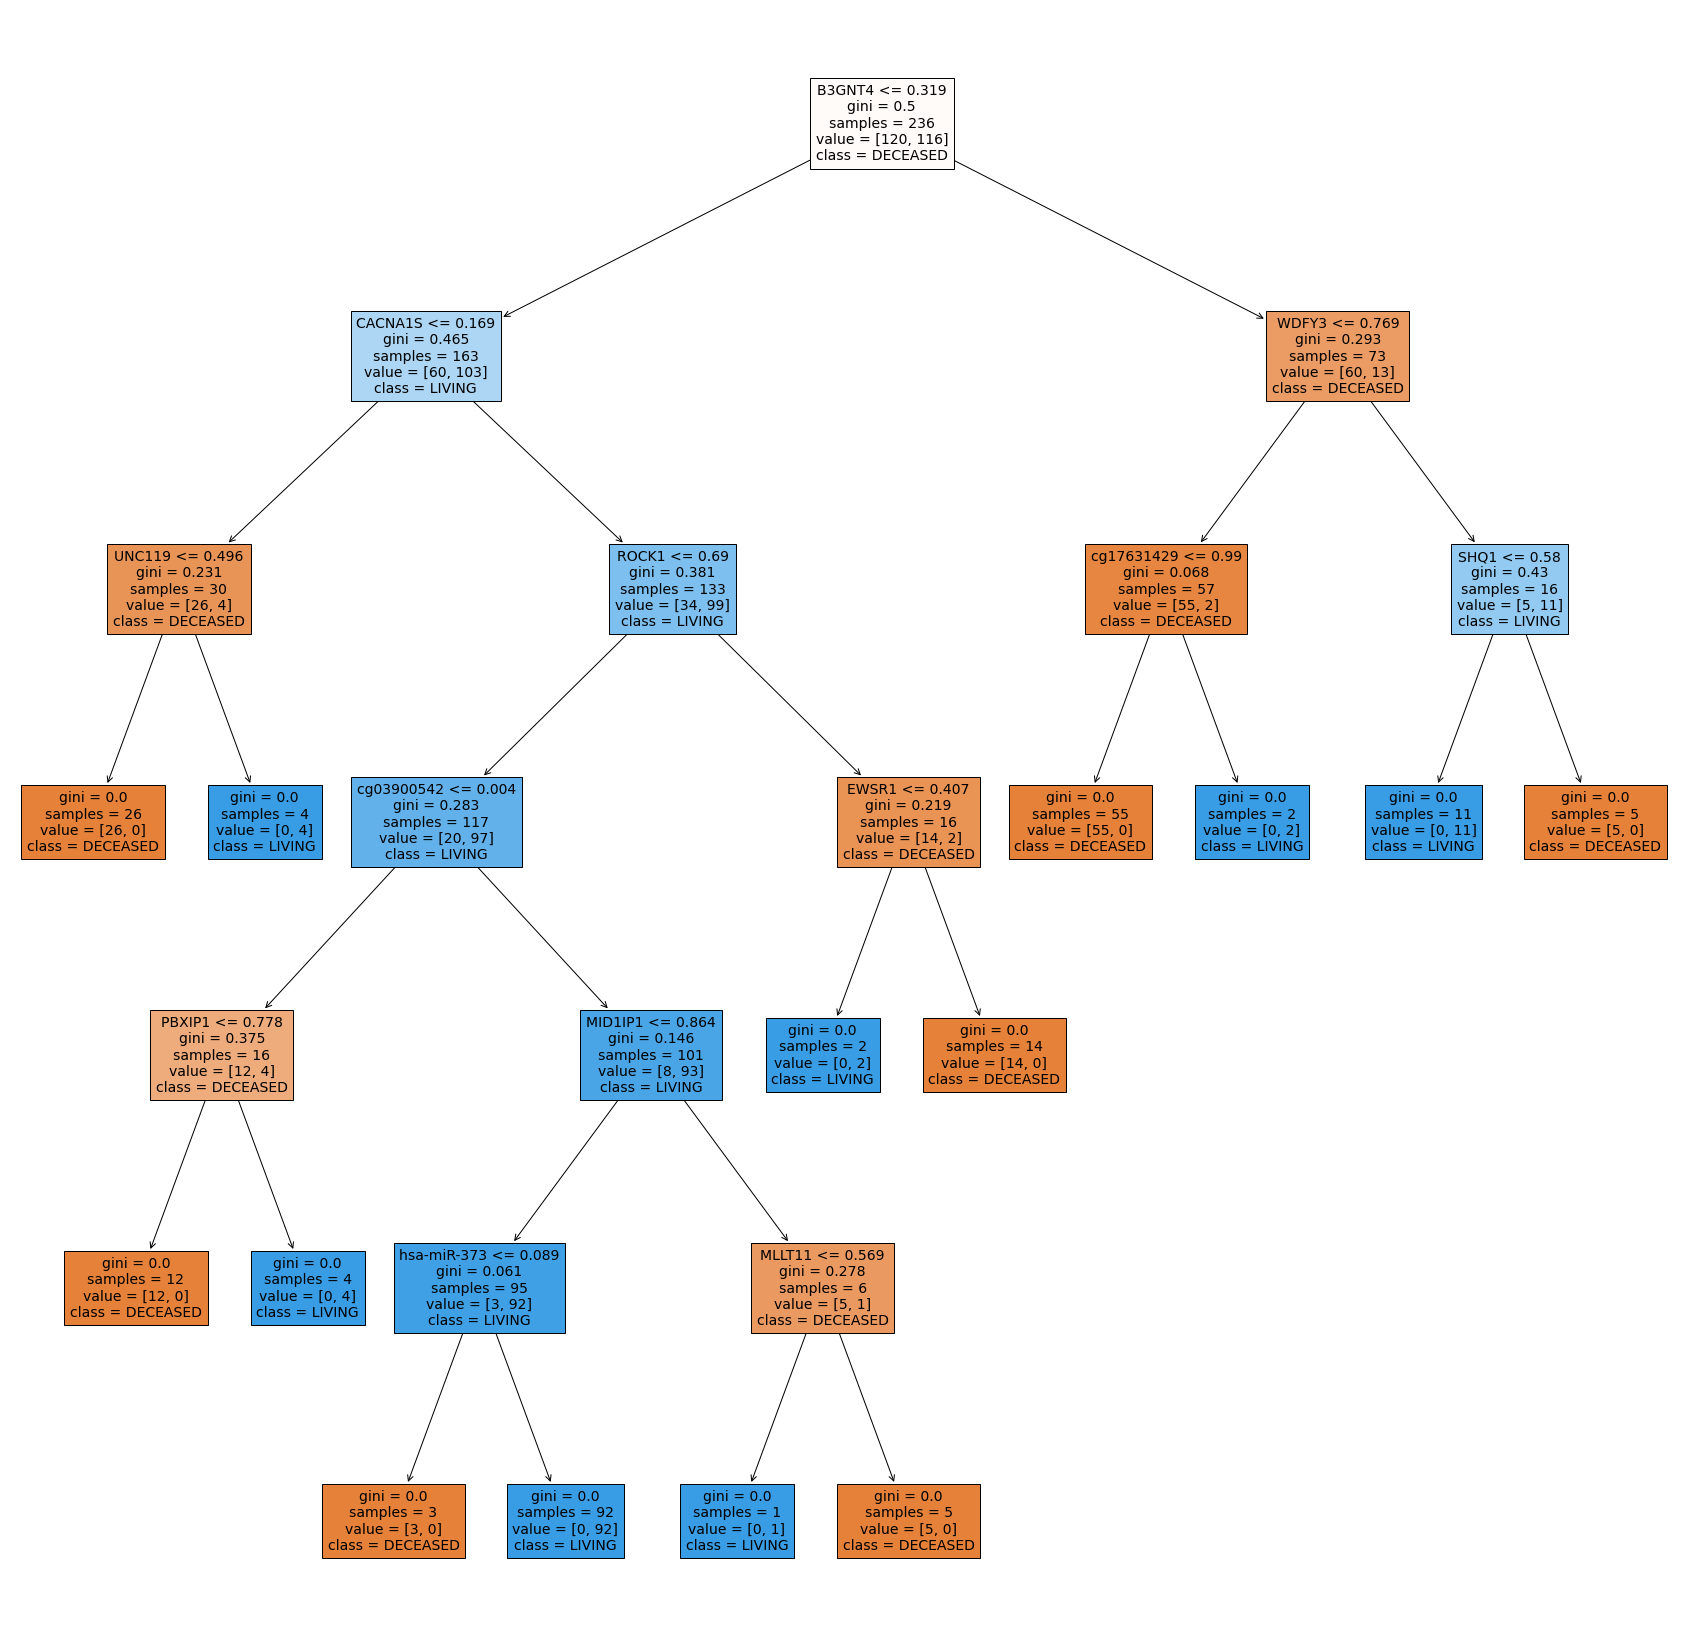

In [33]:
class_names = ['DECEASED','LIVING']
features = list(concDf.columns[:-1])

_, ax = plt.subplots(figsize=(30,30)) # Resize figure
tree.plot_tree(clf,feature_names=features,class_names=class_names ,filled=True, ax=ax)
plt.show()

### Λοιπά για αναφορά

In [44]:
genesN['CDE_vital_status'].value_counts()

DECEASED    169
LIVING       61
Name: CDE_vital_status, dtype: int64

In [45]:
methyN['CDE_vital_status'].value_counts()

DECEASED    169
LIVING       61
Name: CDE_vital_status, dtype: int64

In [46]:
mirnaN['CDE_vital_status'].value_counts()

DECEASED    169
LIVING       61
Name: CDE_vital_status, dtype: int64

In [47]:
concDf['CDE_vital_status'].value_counts()

DECEASED    169
LIVING       61
Name: CDE_vital_status, dtype: int64

In [50]:
data = concDf.values
X, y = data[:, :-1], data[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) #, random_state=1

In [51]:
print('X_train:',X_train.shape)
print('X_test:',X_test.shape)
print('y_train:',y_train.shape)
print('y_test:',y_test.shape)

X_train: (161, 17576)
X_test: (69, 17576)
y_train: (161,)
y_test: (69,)


In [56]:
counter = Counter(y)
print(counter)

Counter({'DECEASED': 169, 'LIVING': 61})


In [59]:
exp.T.describe()

,AACS,FSTL1,ELMO2,CREB3L1,RPS11,PNMA1,MMP2,SAMD4A,SMARCD3,A4GNT,...,KIAA0802,DHRS2,RAB8A,SGEF,PIK3IP1,RPS27,SNRPD2,SLC39A6,CTSC,AQP7
count,538.000000,538.000000,538.000000,538.000000,538.000000,538.000000,538.000000,538.000000,538.000000,538.000000,...,538.000000,538.000000,538.000000,538.000000,538.000000,538.000000,538.000000,538.000000,538.000000,538.000000
mean,6.857476,9.698384,7.033371,4.798021,10.717471,9.540024,7.712223,5.563474,8.322169,4.381581,...,6.626050,4.238019,8.659857,5.479921,6.061114,13.092543,11.220665,8.878248,9.053156,3.858680
std,0.580120,1.057241,0.685507,0.498979,0.393487,0.821276,1.175252,0.379776,1.036997,0.197806,...,0.815168,0.566826,0.636302,0.883631,0.601656,0.323572,0.535032,0.725665,1.191136,0.229216
min,5.536622,3.662355,4.930723,3.931335,9.643697,5.443112,3.793852,4.827805,3.674979,3.892355,...,4.677598,3.651946,5.843530,3.919830,4.478297,11.663411,8.858079,5.673272,5.499304,3.359786
25%,6.486874,9.152143,6.675970,4.422475,10.451898,9.213701,7.095800,5.286227,7.972591,4.230066,...,6.044459,4.008727,8.338326,4.827340,5.621027,12.900922,10.869721,8.501845,8.345613,3.696530
50%,6.829574,9.835648,7.057627,4.737883,10.653345,9.663865,7.779782,5.557519,8.500311,4.369468,...,6.627615,4.120118,8.735155,5.321489,6.019332,13.119180,11.248212,8.956954,9.071602,3.828434
75%,7.155040,10.396886,7.499242,5.036134,10.913628,10.067844,8.441331,5.777569,8.981484,4.499589,...,7.107895,4.260605,9.089152,5.950113,6.468787,13.329416,11.603428,9.333969,9.870845,3.978038
max,9.394954,12.059550,8.919199,8.120004,12.143343,11.417741,11.248461,7.825115,10.265944,5.231504,...,9.927499,10.938656,10.077047,8.402981,8.172227,13.829119,12.644984,11.507749,12.033929,5.174750


In [60]:
genesN.describe()

,AACS,FSTL1,ELMO2,CREB3L1,RPS11,PNMA1,MMP2,SAMD4A,SMARCD3,A4GNT,...,KIAA0802,DHRS2,RAB8A,SGEF,PIK3IP1,RPS27,SNRPD2,SLC39A6,CTSC,AQP7
count,230.000000,230.000000,230.000000,230.000000,230.000000,230.000000,230.000000,230.000000,230.000000,230.000000,...,230.000000,230.000000,230.000000,230.000000,230.000000,230.000000,230.000000,230.000000,230.000000,230.000000
mean,0.368888,0.740680,0.618194,0.194603,0.358460,0.678348,0.588200,0.379900,0.696455,0.319337,...,0.374688,0.075382,0.541103,0.331456,0.469962,0.608444,0.606363,0.568184,0.513792,0.255346
std,0.130531,0.135118,0.194964,0.125225,0.190049,0.167652,0.173836,0.194197,0.182276,0.167203,...,0.161551,0.097937,0.187968,0.202467,0.193942,0.175338,0.156862,0.119211,0.204521,0.129892
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.289473,0.679618,0.507440,0.101155,0.230263,0.603674,0.502323,0.225978,0.623180,0.204820,...,0.259979,0.036849,0.437403,0.192292,0.330410,0.488926,0.509113,0.505504,0.381920,0.164945
50%,0.373759,0.755946,0.631930,0.179011,0.321386,0.711946,0.598653,0.369299,0.733030,0.311800,...,0.372442,0.053821,0.547587,0.283126,0.461762,0.622981,0.610930,0.580743,0.510339,0.237879
75%,0.434407,0.826870,0.750269,0.253213,0.449348,0.790654,0.697849,0.492338,0.808007,0.400245,...,0.467614,0.070622,0.680152,0.462418,0.603443,0.741940,0.716861,0.639819,0.647311,0.316212
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [62]:
concDf.describe()

,AACS,FSTL1,ELMO2,CREB3L1,RPS11,PNMA1,MMP2,SAMD4A,SMARCD3,A4GNT,...,kshv-miR-K12-3*,kshv-miR-K12-4-3p,kshv-miR-K12-4-5p,kshv-miR-K12-5,kshv-miR-K12-6-3p,kshv-miR-K12-6-5p,kshv-miR-K12-7,kshv-miR-K12-8,kshv-miR-K12-9,kshv-miR-K12-9*
count,230.000000,230.000000,230.000000,230.000000,230.000000,230.000000,230.000000,230.000000,230.000000,230.000000,...,230.000000,230.000000,230.000000,230.000000,230.000000,230.000000,230.000000,230.000000,230.000000,230.000000
mean,0.368888,0.740680,0.618194,0.194603,0.358460,0.678348,0.588200,0.379900,0.696455,0.319337,...,0.139284,0.193929,0.222440,0.220454,0.144289,0.114272,0.216873,0.362189,0.236601,0.400817
std,0.130531,0.135118,0.194964,0.125225,0.190049,0.167652,0.173836,0.194197,0.182276,0.167203,...,0.094440,0.130031,0.120680,0.117467,0.089883,0.100502,0.137445,0.160126,0.094389,0.130272
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.289473,0.679618,0.507440,0.101155,0.230263,0.603674,0.502323,0.225978,0.623180,0.204820,...,0.089842,0.123145,0.160290,0.157541,0.109019,0.069842,0.138561,0.260806,0.190238,0.362058
50%,0.373759,0.755946,0.631930,0.179011,0.321386,0.711946,0.598653,0.369299,0.733030,0.311800,...,0.118993,0.167010,0.199670,0.199404,0.127740,0.093770,0.173705,0.326342,0.224901,0.385681
75%,0.434407,0.826870,0.750269,0.253213,0.449348,0.790654,0.697849,0.492338,0.808007,0.400245,...,0.156308,0.217910,0.244934,0.251532,0.154480,0.126820,0.246487,0.431369,0.268593,0.415862
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
